# Brain Tumour Segmentation using Cascading CNNs

In [1]:
#### Commands for running on Google Colab
#!cd drive/
#!pwd
#!pip3 install SimpleITK
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_normal
#import pydot
from IPython.display import SVG
from keras.utils import plot_model
#!pip install --upgrade keras
from sklearn.utils import class_weight
from sklearn import metrics
#from zipfile import ZipFile
from utils import *
from figure_functions import *


2024-06-13 01:13:09.712961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and Visualizing the BraTS 2013 Dataset

In [3]:
#dataroot = './HG.zip'
#with ZipFile(dataroot, "r") as datazip:
#  datazip.extractall()

path = '/home/k1mehta/private/228_Project/HG/0001/'
#path = '../HG/0001/'
data, target_labels = load_dataset(path)
print("Data ", data.shape)
print("Labels" , target_labels.shape)

Data  (216, 176, 160, 4)
Labels (176, 216, 160)


Populating the interactive namespace from numpy and matplotlib


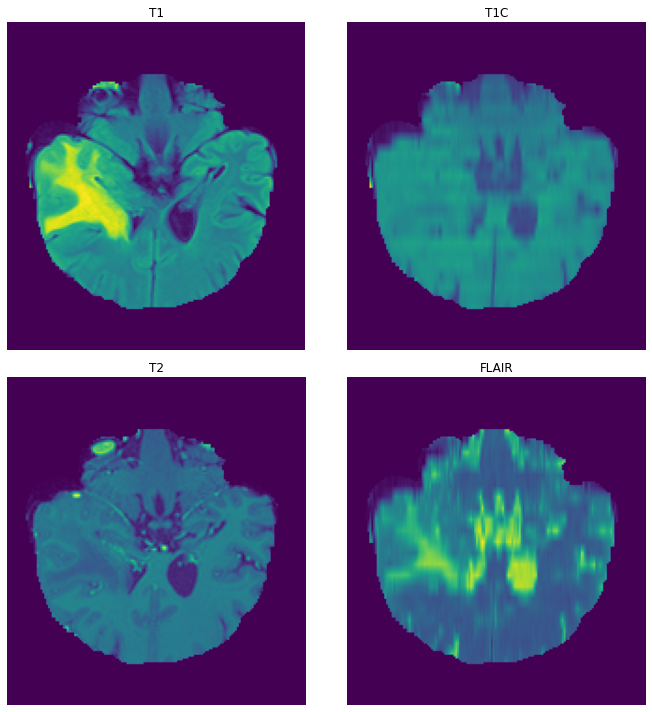

In [4]:

    
%pylab inline
plot_image_channels(data[126,:,:,:].transpose(2, 0, 1))


Populating the interactive namespace from numpy and matplotlib


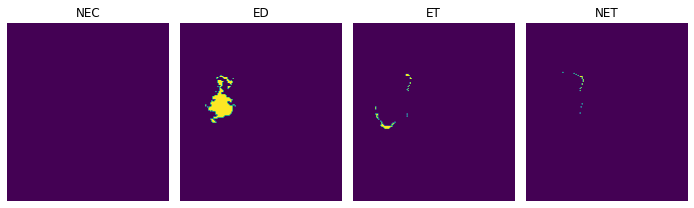

In [5]:
%pylab inline
y_ = target_labels[:,76,:]
y__ = np.zeros((y_.shape[0], y_.shape[1], 4))
for i in range(1,y__.shape[2]):
    y__[:,:,i] = (y_[:,:] == i)
plot_mask_channels4(y__.transpose(2, 0 ,1))

## Cascade CNN Models
### The Two Path building block and Input/MF Cascade CNN

In [6]:
def two_path(x):
    out = Conv2D(64,(7,7),strides=(1,1),padding='valid')(x)
    out = BatchNormalization()(out)
    out1 = Conv2D(64,(7,7),strides=(1,1),padding='valid')(x)
    out1 = BatchNormalization()(out1)
    out = layers.Maximum()([out, out1])
    out = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu')(out)

    out2 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(x)
    out2 = BatchNormalization()(out2)
    out21 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(x)
    out21 = BatchNormalization()(out21)
    out2 = layers.Maximum()([out2, out21])

    out3 = Conv2D(64,(3,3),strides=(1,1),padding='valid')(out)
    out3 = BatchNormalization()(out3)
    out31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid')(out)
    out31 = BatchNormalization()(out31)
    out = layers.Maximum()([out3, out31])
    out = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu')(out)

    out = Concatenate()([out2, out])
    return out


In [7]:
def InputCascade(input_shape1,input_shape2):

    x1_input = Input(input_shape1)
    out1 = two_path(x1_input)
    out1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(out1)
    out1 = BatchNormalization()(out1)

    x2_input = Input(input_shape2)
    x2_input1 = Concatenate()([out1,x2_input])
    out2 = two_path(x2_input1)
    out2 = Conv2D(5,(21,21),strides=(1,1),padding='valid')(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('softmax')(out2)

    model = Model(inputs=[x1_input,x2_input],outputs=out2)
    return model


In [8]:
def MFCascade(input_shape1,input_shape2):

    x1_input = Input(input_shape1)
    out1 = two_path(x1_input)
    out1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(out1)
    out1 = BatchNormalization()(out1)
    
    x2_input = Input(input_shape2)
    out2 = two_path(x2_input)
    out2 = Concatenate()([out1,out2])
    out2 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('softmax')(out2)

    model = Model(inputs=[x1_input,x2_input],outputs=out2)
    return model


In [9]:
#m1 = MFCascade((53,53,4),(33,33,4))
#m1.summary()

## Processing the Dataset for Training

In [10]:
def generate_patches_from_slice(patch_size, x, y, slice_id, pattern='all'):
    big_patch = []
    small_patch = []
    labels = []

    count_x = 0
    count_y = 0

    if(pattern=='tumour'):
        print("Tumorous cell count in this slice: ", np.count_nonzero(y[:, slice_id, :]))
        tumorous = np.argwhere(y[:, slice_id, :] > 0)
        #print("Tumorous: ", tumorous.shape)
        #for i in range(int((patch_size)/2),y.shape[0]-int((patch_size)/2)):
        #  for j in range(int((patch_size)/2),y.shape[2]-int((patch_size)/2)):
        for i, j in tumorous:
            if((i-int((patch_size)/2)>0) and (i+int((patch_size)/2)+1 < x.shape[0]) and (j-int((patch_size)/2)>0) and (j+int((patch_size)/2)+1<x.shape[1])):
                small_patch.append(x[i-16:i+17,j-16:j+17,:])
                big_patch.append(x[i-int((patch_size)/2):i+int((patch_size)/2)+1,j-int((patch_size)/2):j+int((patch_size)/2)+1,:])
                labels.append(y[i,slice_id,j])
    elif(pattern=='all'):
        for i in range(int((patch_size)/2),y.shape[0]-int((patch_size)/2)):
            count_x +=1
            for j in range(int((patch_size)/2),y.shape[2]-int((patch_size)/2)):
                if(count_x == 1):
                    count_y +=1
                small_patch.append(x[i-16:i+17,j-16:j+17,:])
                big_patch.append(x[i-int((patch_size)/2):i+int((patch_size)/2)+1,j-int((patch_size)/2):j+int((patch_size)/2)+1,:])
                labels.append(y[i,slice_id,j])
        print(count_x, count_y)
    else:
        nontumorous_i = np.random.randint(int((patch_size)/2), y.shape[0]-int((patch_size)/2), size=(9*np.count_nonzero(y[slice_id])))
        nontumorous_j = np.random.randint(int((patch_size)/2), y.shape[2]-int((patch_size)/2), size=(9*np.count_nonzero(y[slice_id])))
        for idx in range(nontumorous_i.shape[0]):
            i = nontumorous_i[idx]
            j = nontumorous_j[idx]
            if(x[i-16:i+17,j-16:j+17,:].any != 0):
                small_patch.append(x[i-16:i+17,j-16:j+17,:])
                big_patch.append(x[i-int((patch_size)/2):i+int((patch_size)/2)+1,j-int((patch_size)/2):j+int((patch_size)/2)+1,:])
                labels.append(y[i,slice_id,j])

    big_patch = np.asarray(big_patch)
    small_patch = np.asarray(small_patch)
    labels = np.asarray(labels)
    out = [big_patch,small_patch,labels]
    return out

def patch_gen(data,y,slice_id,model_no,pattern='tumour'):
    d = []
    x = data[slice_id]
    if(x.any() != 0 and y.any() != 0):
        #InputCascade
        if(model_no == 1):
            d = generate_patches_from_slice(65,x,y,slice_id,pattern)
        #MFCascade
        elif(model_no == 2):
            d = generate_patches_from_slice(56,x,y,slice_id,pattern)
        #TwoPathCNN
        elif(model_no == 3):
            d = generate_patches_from_slice(53,x,y,slice_id,pattern)

    return d

## Training the InputCascadeCNN model

In [11]:
m1 = InputCascade((65,65,4),(33,33,4))
m1.summary()
m1 = keras.models.load_model('InputCascade_step_all.h5')
m1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

2024-06-13 01:13:27.096397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18110 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 2g.20gb, pci bus id: 0000:88:00.0, compute capability: 8.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 65, 65, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 59, 59,    │     12,608 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 59, 59,    │     12,608 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 59, 59,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 59, 59,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maximum (Maximum)   │ (None, 59, 59,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     65,600 │ maximum[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 54, 54,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 54, 54,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 53, 53,    │    108,320 │ input_layer[0][0] │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 53, 53,    │    108,320 │ input_layer[0][0] │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 53, 53,    │        640 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 53, 53,    │        640 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maximum_2 (Maximum) │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maximum_1 (Maximum) │ (None, 53, 53,    │          0 │ batch_normalizat

 Total params: 2,089,778 (7.97 MB)

 Trainable params: 2,087,454 (7.96 MB)

 Non-trainable params: 2,324 (9.08 KB)

In [13]:
#path = '../HG/'
path = '/home/k1mehta/private/228_Project/HG/'
fold = os.listdir(path)
fold.sort(key=str.lower)

starting_slice_number = 65
ending_slice_number = 125
slice_split = 3
step_one = False
step_two = False
one_shot = False

for path in fold:
    print("Patient: ", path)
    path = '/home/k1mehta/private/228_Project/HG/'+path
    #path = '../HG/' + path
    data, target_labels = load_dataset(path)
    print("Data: ", data.shape)
    print("Labels: ", target_labels.shape)
    info = []

    # Creating patches for each slice and training(slice-wise)
    for i in range(data.shape[0]):
        if((i > starting_slice_number) and (i < ending_slice_number) and (i%slice_split!=0) and (step_one==True)):
            print('Slice no:'+str(i))
            d = patch_gen(data,target_labels,i,1,pattern='tumour')
            if(len(d) != 0):
                y = np.zeros((d[2].shape[0],1,1,5))
                for j in range(y.shape[0]):
                    y[j,:,:,d[2][j]] = 1
                big_patch = np.asarray(d[0])
                small_patch = np.asarray(d[1])
                print("Big Patch: ", big_patch.shape, " Small Patch: ", small_patch.shape, " Labels: ", y.shape)
                #class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(d[2]), y=d[2])
                #print(np.unique(d[2]))
                info.append(m1.fit([big_patch,small_patch],y,epochs=10,batch_size=128))
                m1.save('InputCascade_step_one.h5')

    for i in range(data.shape[0]):
        if((i > starting_slice_number) and (i < ending_slice_number) and (i%slice_split!=0) and (step_two==True)):
            print('Slice no:'+str(i))
            d = patch_gen(data,target_labels,i,1,pattern='random')
            if(len(d) != 0):
                y = np.zeros((d[2].shape[0],1,1,5))
                for j in range(y.shape[0]):
                    y[j,:,:,d[2][j]] = 1
                big_patch = np.asarray(d[0])
                small_patch = np.asarray(d[1])
                print("Big Patch: ", big_patch.shape, " Small Patch: ", small_patch.shape, " Labels: ", y.shape)
                #class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(d[2]), y=d[2])
                #print(np.unique(d[2]))
                info.append(m1.fit([big_patch,small_patch],y,epochs=2,batch_size=128))
                m1.save('InputCascade_step_two.h5')
                
    for i in range(data.shape[0]):
        if((i > starting_slice_number) and (i < ending_slice_number) and (i%slice_split!=0) and (one_shot==True)):
            print('Slice no:'+str(i))
            d = patch_gen(data,target_labels,i,1,pattern='all')
            if(len(d) != 0):
                y = np.zeros((d[2].shape[0],1,1,5))
                for j in range(y.shape[0]):
                    y[j,:,:,d[2][j]] = 1
                big_patch = np.asarray(d[0])
                small_patch = np.asarray(d[1])
                print("Big Patch: ", big_patch.shape, " Small Patch: ", small_patch.shape, " Labels: ", y.shape)
                #class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(d[2]), y=d[2])
                #print(np.unique(d[2]))
                info.append(m1.fit([big_patch,small_patch],y,epochs=5,batch_size=128))
                m1.save('InputCascade_step_all.h5')


    break


Patient:  0001
Data:  (216, 176, 160, 4)
Labels:  (176, 216, 160)


## Validating the performance of Cascade CNNs

In [14]:
model = keras.models.load_model('InputCascade_step_all.h5')
#path = '../HG/0001'
path = '/home/k1mehta/private/228_Project/HG/0001'
data, target_labels = load_dataset(path)
info = []


print(data.shape)
print(target_labels.shape)
d = patch_gen(data,target_labels,110,1,'all')
if(len(d) != 0):
    y = np.zeros((d[2].shape[0],1,1,5))
    for j in range(y.shape[0]):
        y[j,:,:,d[2][j]] = 1
    big_patch = d[0]
    small_patch = d[1]
    pred = model.predict([big_patch,small_patch],batch_size = 256)
    pred = np.around(pred)
    pred1 = np.argmax(pred.reshape(y.shape[0],5)[:,1:4],axis = 1)
    y1 = np.argmax(y.reshape(y.shape[0],5)[:,1:4],axis = 1)
    accuracy = np.count_nonzero(y1 == pred1)/y1.shape[0]
    print("Accuracy: ", accuracy)

(216, 176, 160, 4)
(176, 216, 160)
112 96


2024-06-13 01:14:03.212199: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560378771440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-13 01:14:03.212276: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 2g.20gb, Compute Capability 8.0
2024-06-13 01:14:03.233216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 01:14:03.933320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


 2/42 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step 

2024-06-13 01:14:28.969420: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step
Accuracy:  0.9813988095238095


Ground Truth


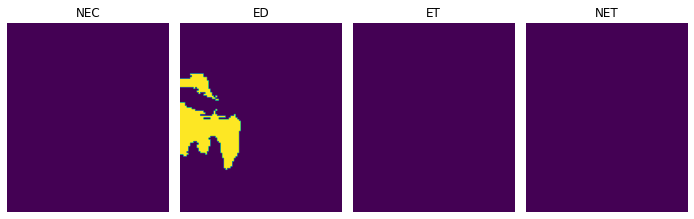

Prediction


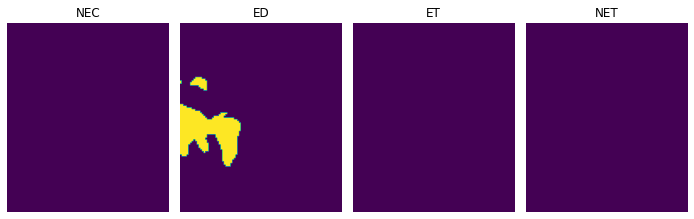

In [15]:
print("Ground Truth")
y_ = y1.reshape(112, 96, 1)
y__ = np.zeros((y_.shape[0], y_.shape[1], 4))
for i in range(1,y__.shape[2]):
    y__[:,:,i] = (y_[:,:,0] == i)
plot_mask_channels4(y__.transpose(2, 0 ,1))

print("Prediction")
y_ = pred1.reshape(112, 96, 1)
y__ = np.zeros((y_.shape[0], y_.shape[1], 4))
for i in range(1,y__.shape[2]):
    y__[:,:,i] = (y_[:,:,0] == i)
plot_mask_channels4(y__.transpose(2, 0 ,1))
#print(np.max(y2))
#print(np.max(pred1))
#plot_image_channels(data[98,144:33,128:33,:])
#plot_image_channels(data[98,33:144,33:128,:])



